In [1]:
import wfdb
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

In [2]:
data_folder = 'training2017'
reference_csv_file = 'training2017/REFERENCE-original.csv'


In [3]:
# Read the reference CSV file
df_reference = pd.read_csv(reference_csv_file, delimiter='\t', header=None)

# Initialize empty lists to store the ECG signals and their corresponding classes
ecg_signals = []
ecg_classes = []

In [4]:
# Create a mapping from file names to classes
class_mapping = dict(zip(df_reference[0].str.split(',').str[0], df_reference[0].str.split(',').str[1]))

In [5]:
# Iterate through the files in the dataset folder, load the ECG signals, and filter for classes A, N, and O
for file_name in tqdm(os.listdir(data_folder), desc="Loading ECG signals"):
    if file_name.endswith('.hea'):
        record = wfdb.rdrecord(os.path.join(data_folder, file_name[:-4]))
        file_class = class_mapping.get(file_name[:-4], None)
        if file_class in ['A', 'N', 'O']:
            ecg_signal = record.p_signal[:, 0]  # Assuming single-channel signal
            ecg_signals.append(ecg_signal)
            ecg_classes.append(file_class)

Loading ECG signals: 100%|██████████| 17059/17059 [00:19<00:00, 885.54it/s] 


In [6]:
# Create a DataFrame to save the ECG signals and their corresponding classes
ecg_df = pd.DataFrame({'class': ecg_classes, 'signal': ecg_signals})



In [7]:
# Count the occurrences of each class in the 'class' column
class_counts = ecg_df['class'].value_counts()

# Print the class counts
print(class_counts)

class
N    5154
O    2557
A     771
Name: count, dtype: int64


In [10]:
print(ecg_df.head())

  class                                             signal
0     O  [0.1, 0.101, 0.102, 0.104, 0.104, 0.105, 0.106...
1     N  [-0.172, -0.205, -0.245, -0.272, -0.285, -0.29...
2     O  [-0.028, -0.049, -0.064, -0.075, -0.081, -0.08...
3     N  [-0.076, -0.085, -0.09, -0.089, -0.082, -0.059...
4     O  [-0.16, -0.198, -0.237, -0.261, -0.278, -0.289...


In [23]:
# Assuming all ECG signals have the same length, you can find the number of samples in one of the signals
num_samples = len(ecg_signals[0])

print(f"Number of samples in the ECG signals: {num_samples}")


Number of samples in the ECG signals: 9000


In [24]:
# Define the length of the segments
segment_length = 500

# Initialize empty lists to store the segmented signals and their corresponding classes
segmented_ecg_signals = []
segmented_ecg_classes = []

# Iterate through the ECG signals and segment them
for i, ecg_signal in enumerate(ecg_signals):
    # Calculate the number of segments that can be obtained from the current ECG signal
    num_segments = len(ecg_signal) // segment_length

    # Extract and store each segment along with its corresponding class
    for j in range(num_segments):
        start_idx = j * segment_length
        end_idx = (j + 1) * segment_length
        segment = ecg_signal[start_idx:end_idx]
        class_label = ecg_classes[i]
        
        segmented_ecg_signals.append(segment)
        segmented_ecg_classes.append(class_label)

# Create a DataFrame to store the segmented ECG signals and their corresponding classes
segmented_ecg_df = pd.DataFrame({'class': segmented_ecg_classes, 'signal': segmented_ecg_signals})


In [25]:
# Count the occurrences of each class in the 'class' column
class_counts = segmented_ecg_df['class'].value_counts()

# Print the class counts
print(class_counts)

class
N    98029
O    52097
A    14558
Name: count, dtype: int64


In [26]:
print(segmented_ecg_df.head())

  class                                             signal
0     O  [0.1, 0.101, 0.102, 0.104, 0.104, 0.105, 0.106...
1     O  [-0.055, -0.044, -0.031, -0.015, 0.004, 0.016,...
2     O  [0.004, 0.002, 0.0, -0.001, -0.002, -0.003, -0...
3     O  [0.087, 0.184, 0.207, 0.204, 0.167, 0.121, 0.0...
4     O  [-0.021, -0.02, -0.015, -0.007, 0.0, 0.006, 0....


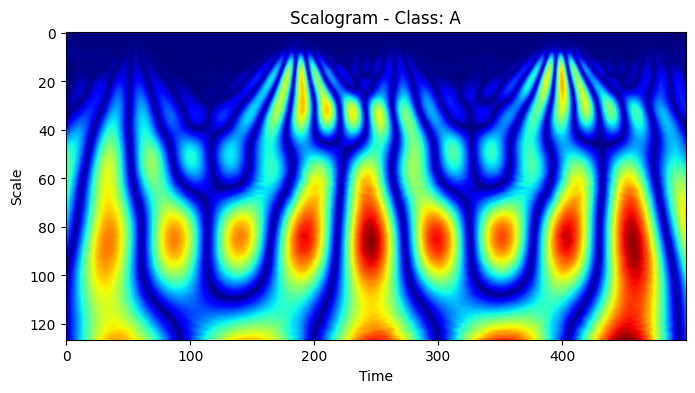

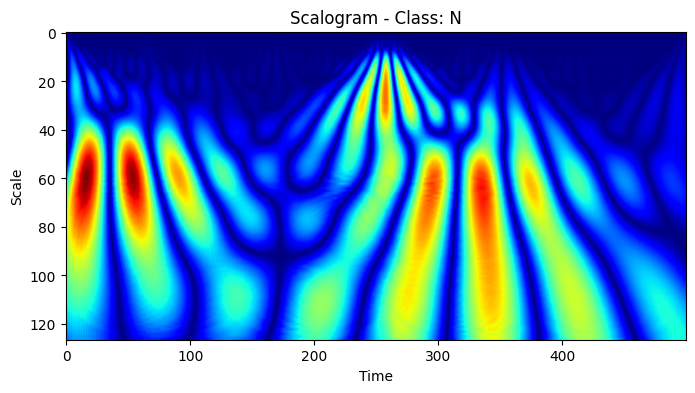

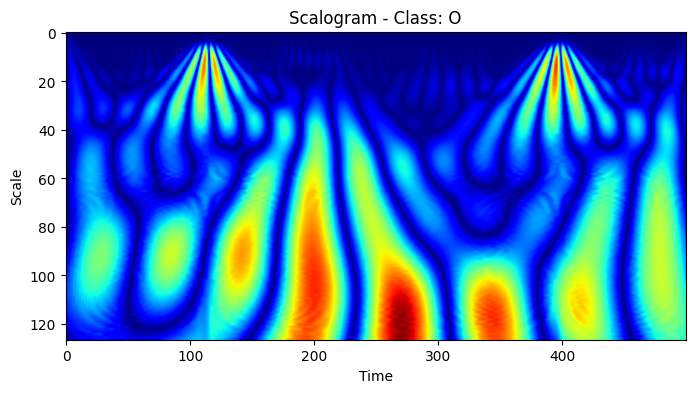

In [29]:
import matplotlib.pyplot as plt
import pywt
import numpy as np

# Function to generate scalogram plots
def plot_scalogram(ecg_signal, class_label):
    # Define the scales and positions for the CWT
    scales = np.arange(1, 128)  # Define the range of scales
    positions = np.arange(0, len(ecg_signal))
    
    # Initialize an empty scalogram
    scalogram = np.zeros((len(scales), len(ecg_signal)))
    
    # Perform CWT and populate the scalogram
    for i, scale in enumerate(scales):
        coef, _ = pywt.cwt(ecg_signal, [scale], 'morl')
        scalogram[i, :] = np.abs(coef)
    
    # Create the scalogram plot
    plt.figure(figsize=(8, 4))
    plt.imshow(scalogram, aspect='auto', cmap='jet', interpolation='bilinear')
    plt.title(f'Scalogram - Class: {class_label}')
    plt.xlabel('Time')
    plt.ylabel('Scale')
    plt.show()

# Extract and plot ECG signals for each class (A, N, O)
for class_label in ['A', 'N', 'O']:
    subset = segmented_ecg_df[segmented_ecg_df['class'] == class_label]
    ecg_signal = subset['signal'].iloc[0]  # Take the first signal of the class
    plot_scalogram(ecg_signal, class_label)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pywt  # Import the PyWavelets library
from tqdm import tqdm

# Define the output directory
output_dir = 'dataset'

# Create subdirectories for each class if they don't already exist
classes = ['A', 'N', 'O']
for class_name in classes:
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)

# Initialize tqdm with the total number of images to be saved
total_images = len(segmented_ecg_df)
pbar = tqdm(total=total_images, desc="Saving Images")

# Iterate through the segmented ECG data
for index, row in segmented_ecg_df.iterrows():
    # Extract class and signal
    class_name = row['class']
    ecg_signal = row['signal']
    
    # Apply Continuous Wavelet Transform (CWT)
    scales = np.arange(1, 128)  # Define the scales for CWT
    coefficients, frequencies = pywt.cwt(ecg_signal, scales, 'morl')  # Use Morlet wavelet

    # Create a Scalogram
    plt.figure(figsize=(2.27, 2.27))  # Set figure size to match the desired output size
    plt.imshow(abs(coefficients), cmap='jet', aspect='auto')  # Visualize using 'jet' colormap
    plt.axis('off')  # Turn off axis labels
    
    # Save the image to the appropriate class folder
    image_filename = f"{index}.png"
    image_path = os.path.join(output_dir, class_name, image_filename)
    plt.savefig(image_path, bbox_inches='tight', pad_inches=0, format='png', dpi=100)
    plt.close()
    
    # Update the progress bar
    pbar.update(1)

# Close the progress bar
pbar.close()

print("Images have been saved to the specified folders.")
